In [107]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/detection-of-parkinson-disease/parkinsons.csv


In [108]:
import numpy as np
import pandas as pd
import os, sys
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Loading the Dataset

In [109]:
df=pd.read_csv('../input/detection-of-parkinson-disease/parkinsons.csv')

In [110]:
df

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


### Exploring the data

In [111]:
a= list(df.columns)
a

['name',
 'MDVP:Fo(Hz)',
 'MDVP:Fhi(Hz)',
 'MDVP:Flo(Hz)',
 'MDVP:Jitter(%)',
 'MDVP:Jitter(Abs)',
 'MDVP:RAP',
 'MDVP:PPQ',
 'Jitter:DDP',
 'MDVP:Shimmer',
 'MDVP:Shimmer(dB)',
 'Shimmer:APQ3',
 'Shimmer:APQ5',
 'MDVP:APQ',
 'Shimmer:DDA',
 'NHR',
 'HNR',
 'status',
 'RPDE',
 'DFA',
 'spread1',
 'spread2',
 'D2',
 'PPE']

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
name                195 non-null object
MDVP:Fo(Hz)         195 non-null float64
MDVP:Fhi(Hz)        195 non-null float64
MDVP:Flo(Hz)        195 non-null float64
MDVP:Jitter(%)      195 non-null float64
MDVP:Jitter(Abs)    195 non-null float64
MDVP:RAP            195 non-null float64
MDVP:PPQ            195 non-null float64
Jitter:DDP          195 non-null float64
MDVP:Shimmer        195 non-null float64
MDVP:Shimmer(dB)    195 non-null float64
Shimmer:APQ3        195 non-null float64
Shimmer:APQ5        195 non-null float64
MDVP:APQ            195 non-null float64
Shimmer:DDA         195 non-null float64
NHR                 195 non-null float64
HNR                 195 non-null float64
status              195 non-null int64
RPDE                195 non-null float64
DFA                 195 non-null float64
spread1             195 non-null float64
spread2             195 non-null floa

In [113]:
df.shape

(195, 24)

In [114]:
c_d= df.corr(method='pearson')

In [115]:
c_d

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
MDVP:Fo(Hz),1.000000,0.400985,0.596546,-0.118003,-0.382027,-0.076194,-0.112165,-0.076213,-0.098374,-0.073742,...,-0.094732,-0.021981,0.059144,-0.383535,-0.383894,-0.446013,-0.413738,-0.249450,0.177980,-0.372356
MDVP:Fhi(Hz),0.400985,1.000000,0.084951,0.102086,-0.029198,0.097177,0.091126,0.097150,0.002281,0.043465,...,-0.003733,0.163766,-0.024893,-0.166136,-0.112404,-0.343097,-0.076658,-0.002954,0.176323,-0.069543
MDVP:Flo(Hz),0.596546,0.084951,1.000000,-0.139919,-0.277815,-0.100519,-0.095828,-0.100488,-0.144543,-0.119089,...,-0.150737,-0.108670,0.210851,-0.380200,-0.400143,-0.050406,-0.394857,-0.243829,-0.100629,-0.340071
MDVP:Jitter(%),-0.118003,0.102086,-0.139919,1.000000,0.935714,0.990276,0.974256,0.990276,0.769063,0.804289,...,0.746635,0.906959,-0.728165,0.278220,0.360673,0.098572,0.693577,0.385123,0.433434,0.721543
MDVP:Jitter(Abs),-0.382027,-0.029198,-0.277815,0.935714,1.000000,0.922911,0.897778,0.922913,0.703322,0.716601,...,0.697170,0.834972,-0.656810,0.338653,0.441839,0.175036,0.735779,0.388543,0.310694,0.748162
MDVP:RAP,-0.076194,0.097177,-0.100519,0.990276,0.922911,1.000000,0.957317,1.000000,0.759581,0.790652,...,0.744919,0.919521,-0.721543,0.266668,0.342140,0.064083,0.648328,0.324407,0.426605,0.670999
MDVP:PPQ,-0.112165,0.091126,-0.095828,0.974256,0.897778,0.957317,1.000000,0.957319,0.797826,0.839239,...,0.763592,0.844604,-0.731510,0.288698,0.333274,0.196301,0.716489,0.407605,0.412524,0.769647
Jitter:DDP,-0.076213,0.097150,-0.100488,0.990276,0.922913,1.000000,0.957319,1.000000,0.759555,0.790621,...,0.744901,0.919548,-0.721494,0.266646,0.342079,0.064026,0.648328,0.324377,0.426556,0.671005
MDVP:Shimmer,-0.098374,0.002281,-0.144543,0.769063,0.703322,0.759581,0.797826,0.759555,1.000000,0.987258,...,0.987626,0.722194,-0.835271,0.367430,0.447424,0.159954,0.654734,0.452025,0.507088,0.693771
MDVP:Shimmer(dB),-0.073742,0.043465,-0.119089,0.804289,0.716601,0.790652,0.839239,0.790621,0.987258,1.000000,...,0.963202,0.744477,-0.827805,0.350697,0.410684,0.165157,0.652547,0.454314,0.512233,0.695058


### Visualization (heatmaps)

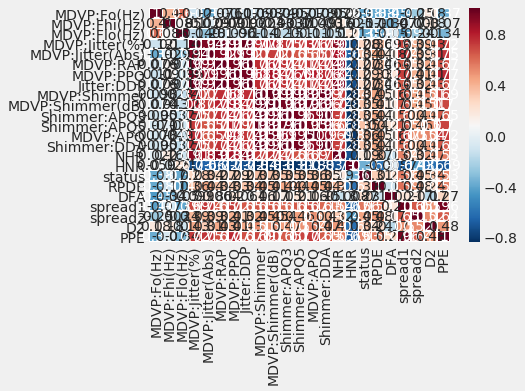

In [159]:
import seaborn as sb
sb.heatmap(c_d, 
            xticklabels=c_d.columns,
            yticklabels=c_d.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [117]:
# Correlation matrix
import matplotlib.pyplot as plt # plotting
df.dataframeName = 'parkinsons.csv'
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

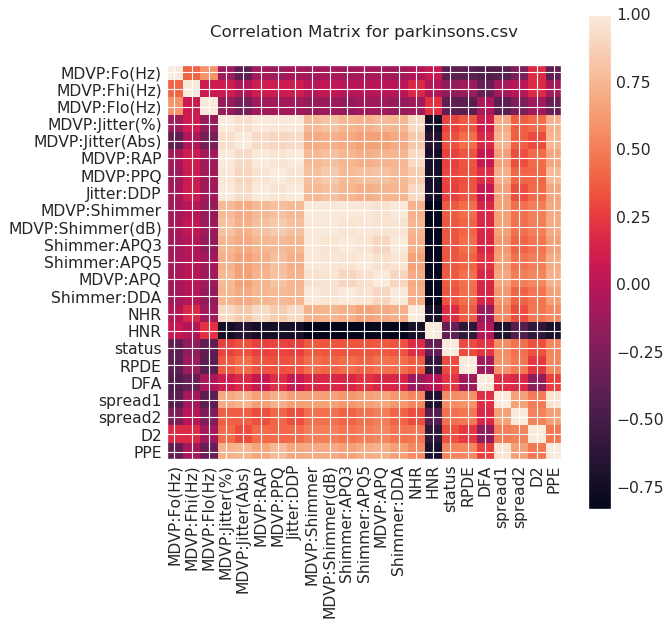

In [121]:
from mpl_toolkits.mplot3d import Axes3D
plotCorrelationMatrix(df, 8)

In [122]:
#features and labels 
features =df.loc[:,df.columns!='status'].values[:,1:]
labels=df.loc[:,'status'].values

In [123]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Cheacking for the imbalances 

In [124]:
print(labels[labels==1].shape[0], labels[labels==0].shape[0])

147 48


In [125]:
df.status.value_counts()

1    147
0     48
Name: status, dtype: int64

In [126]:
park_df = pd.DataFrame(df.status.value_counts())


In [127]:
park_df

,status
1,147
0,48


In [128]:
park_df['Count'] = park_df.index
park_df

,status,Count
1,147,1
0,48,0


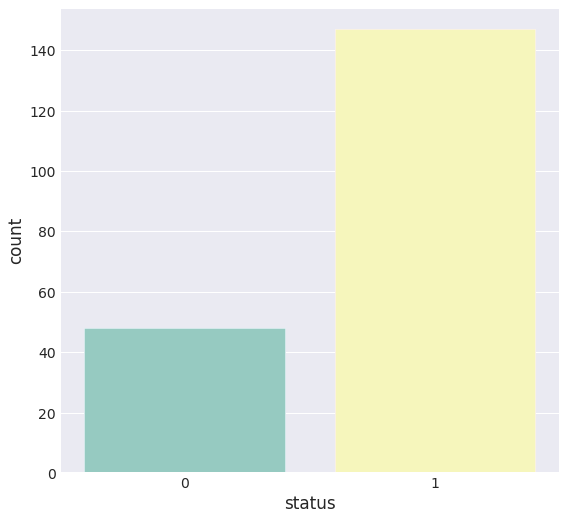

In [161]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context({"figure.figsize": (8, 8)})
sns.barplot(x = 'Count', y = 'status', data =park_df )
#sns.countplot(df['status'],label='Count',palette="Set3")

### Scaling the distribution

In [130]:
# scaling and normalization
scaler=MinMaxScaler((-1,1))
x=scaler.fit_transform(features)
y=labels


### Splitting the dataset

In [131]:
# split the data set 
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=7)

In [132]:
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (156, 22)
Training Labels Shape: (156,)
Testing Features Shape: (39, 22)
Testing Labels Shape: (39,)


# Building Model

### Baseline predictions

In [133]:
# The baseline predictions are the historical averages
baseline_preds = x_test[:, a.index('status')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))


Average baseline error:  0.76


#### Random forest

In [134]:
# Import the model we are using
from sklearn.ensemble import  RandomForestClassifier
# Instantiate model with 1000 decision trees
#rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = RandomForestClassifier(max_depth=2, random_state=0)
# Train the model on training data
rf.fit(x_train,y_train);

In [135]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.15


In [136]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


Mean Absolute Error: 0.15384615384615385
Mean Squared Error: 0.15384615384615385
Root Mean Squared Error: 0.3922322702763681


In [137]:
from sklearn.metrics import average_precision_score,confusion_matrix,f1_score,recall_score,roc_auc_score,precision_score
confusion_matrix(y_test,predictions)

array([[ 3,  4],
       [ 2, 30]])

In [138]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.88      0.94      0.91        32

    accuracy                           0.85        39
   macro avg       0.74      0.68      0.70        39
weighted avg       0.83      0.85      0.84        39



In [139]:
#recall_score(y_test,predictions)
#f1_score(y_test,predictions)
roc_auc_score(y_test,predictions)

0.6830357142857143

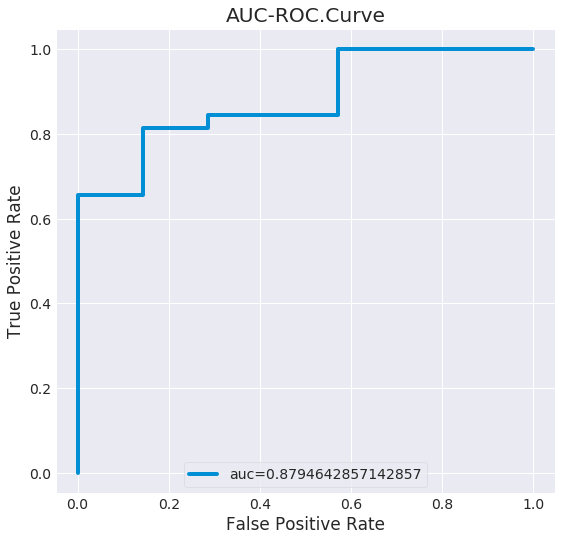

array([0.     , 0.125  , 0.28125, 0.3125 , 0.4375 , 0.65625, 0.65625,
       0.78125, 0.8125 , 0.8125 , 0.84375, 0.84375, 1.     , 1.     ,
       1.     ])

In [140]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

y_pred_proba=rf.predict_proba(x_test)[::,1]
fpr,tpr,threshold=roc_curve(y_test,y_pred_proba)
auc=roc_auc_score(y_test,y_pred_proba)

plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC.Curve')

plt.legend (loc=8)
plt.show()
tpr

In [141]:
rf.score(x_test, y_test)

0.8461538461538461

In [142]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydot
# Limit depth of tree to 3 levels
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 3)
rf_small.fit(x_train,y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = b, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

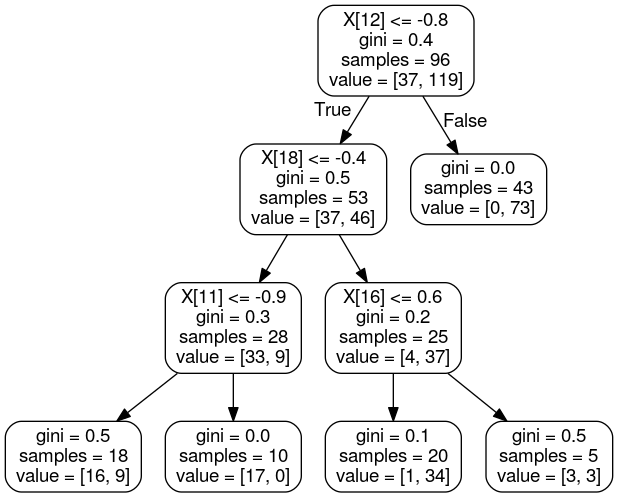

In [143]:
from IPython.display import Image
Image(filename = 'small_tree.png')

In [144]:
b = a.remove('name')

In [145]:
b = a.remove('status')

In [146]:
# feature importance 
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(a, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:70} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: spread1                                                                Importance: 0.2
Variable: PPE                                                                    Importance: 0.12
Variable: MDVP:Fo(Hz)                                                            Importance: 0.11
Variable: MDVP:RAP                                                               Importance: 0.1
Variable: MDVP:APQ                                                               Importance: 0.1
Variable: Shimmer:APQ5                                                           Importance: 0.08
Variable: spread2                                                                Importance: 0.07
Variable: Jitter:DDP                                                             Importance: 0.06
Variable: MDVP:Shimmer                                                           Importance: 0.06
Variable: MDVP:PPQ                                                               Importance: 0.03
Variable: MDVP:Flo(Hz) 

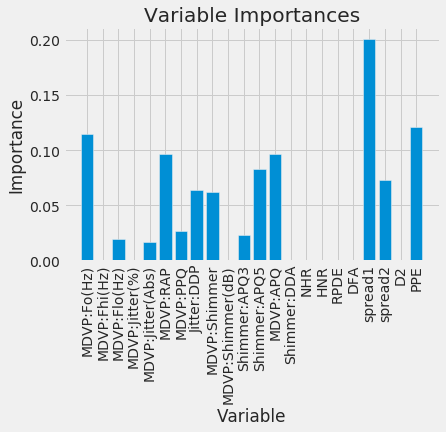

In [147]:

import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values,a, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### AdaBoost

In [148]:
#https://chrisalbon.com/machine_learning/trees_and_forests/adaboost_classifier/
#https://www.datacamp.com/community/tutorials/adaboost-classifier-python
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
svc=SVC(probability=True, kernel='linear')

abc =AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)

model = abc.fit(x_train, y_train)

y_pred = model.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.8974358974358975


In [149]:
from sklearn.metrics import average_precision_score,confusion_matrix,f1_score,recall_score,roc_auc_score,precision_score
confusion_matrix(y_test,y_pred)

array([[ 6,  1],
       [ 3, 29]])

In [150]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.97      0.91      0.94        32

    accuracy                           0.90        39
   macro avg       0.82      0.88      0.84        39
weighted avg       0.91      0.90      0.90        39



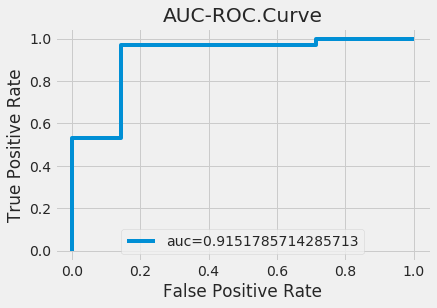

array([0.     , 0.03125, 0.53125, 0.53125, 0.96875, 0.96875, 1.     ,
       1.     ])

In [151]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

y_pred_proba=abc.predict_proba(x_test)[::,1]
fpr,tpr,threshold=roc_curve(y_test,y_pred_proba)
auc=roc_auc_score(y_test,y_pred_proba)

plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC.Curve')

plt.legend (loc=8)
plt.show()
tpr

### XGBoost

In [152]:
model=XGBClassifier()
model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [153]:
y_pred2=model.predict(x_test)
print(accuracy_score(y_test, y_pred2)*100)

94.87179487179486


In [154]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



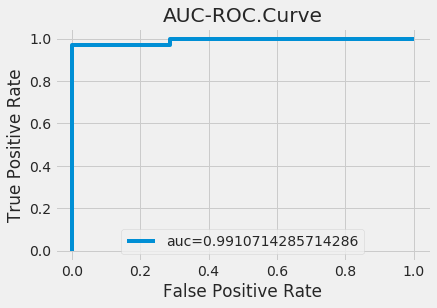

array([0.     , 0.03125, 0.96875, 0.96875, 1.     , 1.     ])

In [155]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

y_pred_proba=model.predict_proba(x_test)[::,1]
fpr,tpr,threshold=roc_curve(y_test,y_pred_proba)
auc=roc_auc_score(y_test,y_pred_proba)

plt.plot(fpr,tpr,label="auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC.Curve')

plt.legend (loc=8)
plt.show()
tpr

### Compare Machine Learning Algorithms

LR: 0.812632 (0.215975)
LDA: 0.792105 (0.187061)
KNN: 0.772895 (0.165015)
CART: 0.742368 (0.179262)
NB: 0.669474 (0.223307)
SVM: 0.838947 (0.216663)
abc: 0.772895 (0.176567)
XGB: 0.809737 (0.180070)
rf: 0.731579 (0.175836)
log: 0.812632 (0.215975)


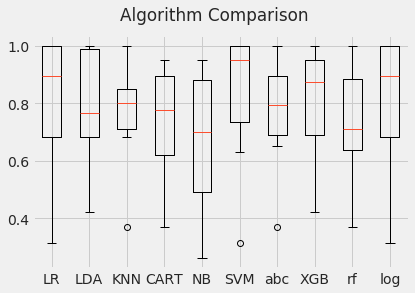

In [156]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
seed = 7
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('abc', AdaBoostClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('rf', RandomForestClassifier()))
models.append(('log', LogisticRegression())) 
# evaluate each model in turn
results = []
a = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, x, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    a.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(a)
plt.show()


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)